root
 |-- id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- content: string (nullable = true)
 |-- language: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- favourites_count: integer (nullable = true)
 |-- reblogs_count: integer (nullable = true)
 |-- score: float (nullable = true)
 |-- label: integer (nullable = false)


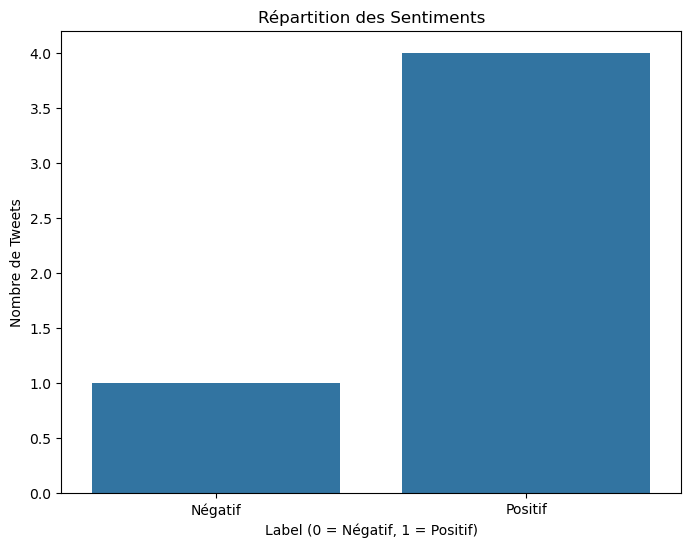

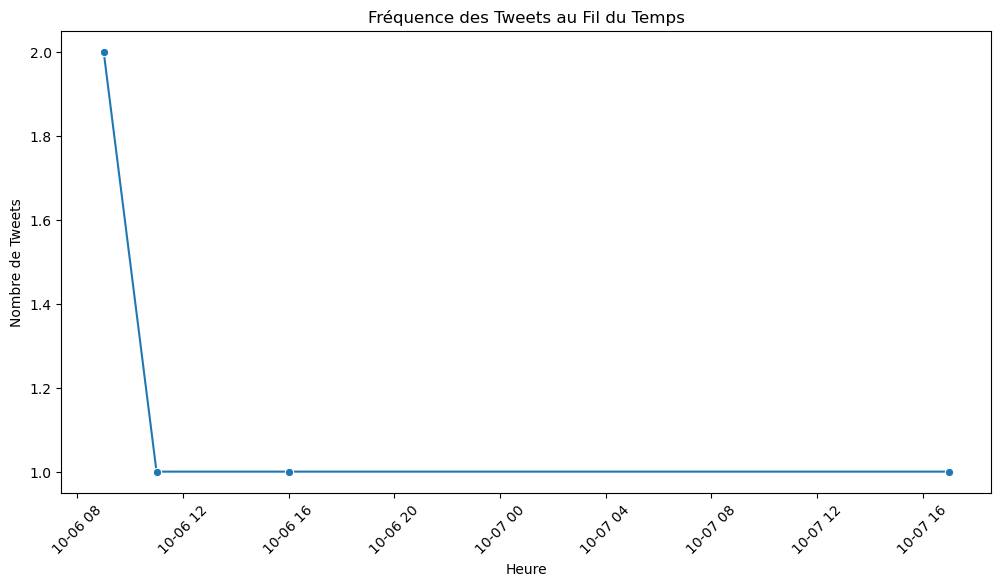

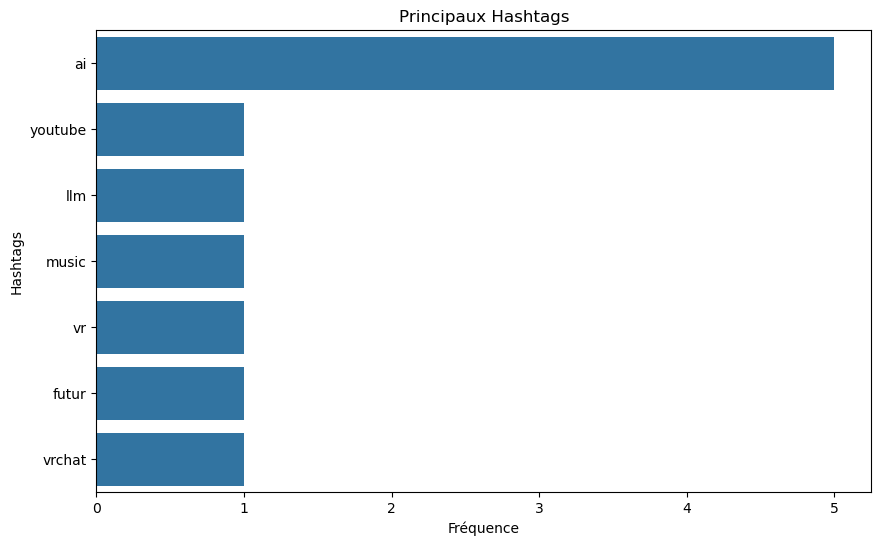

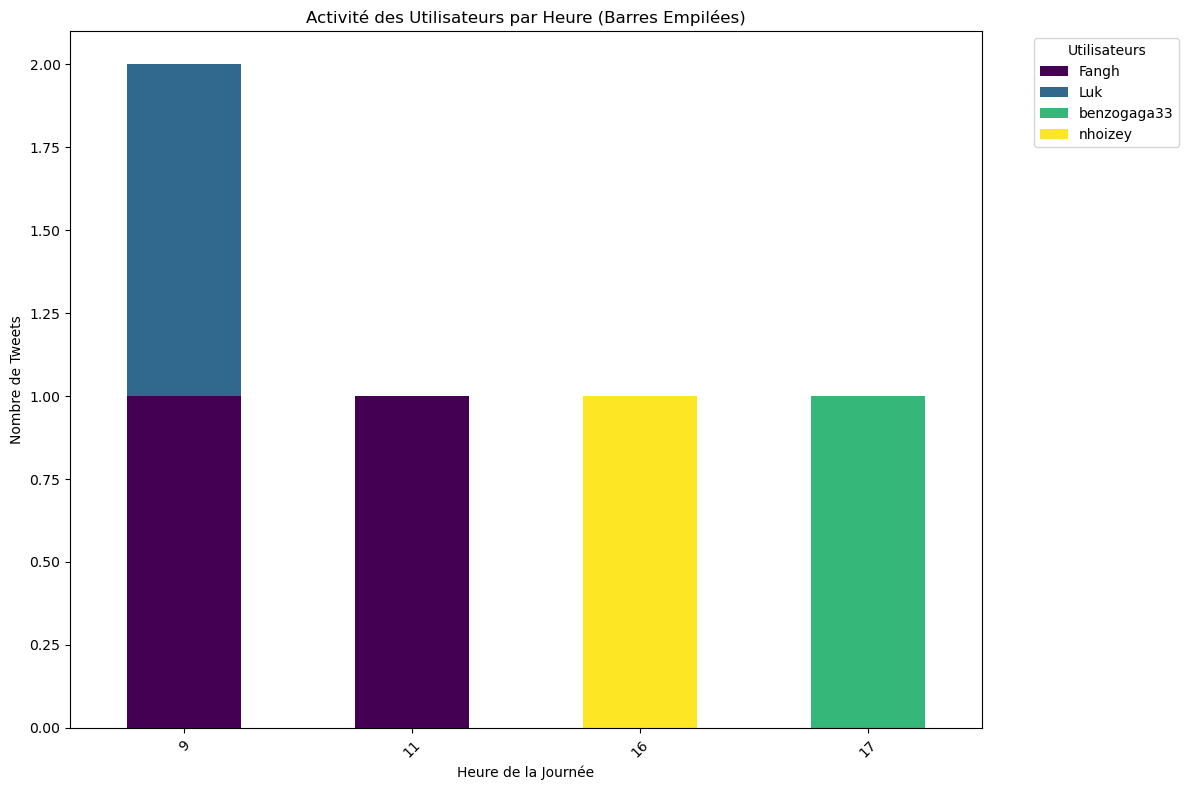

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, udf, explode, window
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.types import FloatType


# Initialiser SparkSession
spark = SparkSession.builder \
    .appName("Visualization") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.2.25") \
    .getOrCreate()

# Paramètres de connexion PostgreSQL
db_url = "jdbc:postgresql://projetfinal5spar-postgres-1:5432/mastodon_data"
db_properties = {
    "user": "user",
    "password": "password",
    "driver": "org.postgresql.Driver"
}

# Charger les données historiques de PostgreSQL
df = spark.read \
    .jdbc(url=db_url, table="mastodon", properties=db_properties)


# Initialiser l'analyseur VADER
analyzer = SentimentIntensityAnalyzer()

# Fonction pour obtenir le score de sentiment
def get_score(text):
    return analyzer.polarity_scores(text)['compound']

# UDF pour appliquer la fonction de sentiment
sentiment = udf(get_score, FloatType())

# Appliquer l'UDF pour obtenir les scores de sentiment
df = df.withColumn("score", sentiment(col("content")))

# Création du champs label et ajout des valeurs
df = df.withColumn("label", when(col("score") >= 0, 1).otherwise(0))



# Afficher le schéma des données
df.printSchema()

# Visualisation 1 : Répartition des sentiments
# Compter le nombre de tweets positifs et négatifs
sentiment_counts = df.groupBy("label").count().toPandas()
plt.figure(figsize=(8, 6))

# Création d'un graphique à barres montrant la répartition des sentiments
sns.barplot(x='label', y='count', data=sentiment_counts)
plt.title('Répartition des Sentiments')
plt.xlabel('Label (0 = Négatif, 1 = Positif)')
plt.ylabel('Nombre de Tweets')
plt.xticks(ticks=[0, 1], labels=['Négatif', 'Positif'])
plt.show()




# Visualisation 2 : Fréquence des tweets au fil du temps
# Compter les tweets par fenêtre d'une heure
hourly_counts = df.groupBy(window(col("timestamp"), "1 hour")).count().orderBy("window").toPandas()

# Extraire les heures pour les afficher sur l'axe x
hourly_counts['hour'] = hourly_counts['window'].apply(lambda x: x.start)

# Créer un graphique linéaire pour montrer l'évolution de la fréquence des tweets au fil du temps
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='count', data=hourly_counts, marker='o')
plt.title("Fréquence des Tweets au Fil du Temps")
plt.xlabel("Heure")
plt.ylabel("Nombre de Tweets")
plt.xticks(rotation=45)
plt.show()



# Visualisation 3 : Principaux hashtags
# Sélectionner et extraire les hashtags des tweets
hashtags = df.select(explode(df.hashtags).alias('hashtag'))

# Compter les occurrences de chaque hashtag et limiter à 10 résultats
hashtag_counts = hashtags.groupBy('hashtag').count().orderBy('count', ascending=False).limit(10).toPandas()

# Créer un graphique à barres horizontales pour montrer les 10 hashtags les plus fréquents
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='hashtag', data=hashtag_counts)
plt.title("Principaux Hashtags")
plt.xlabel("Fréquence")
plt.ylabel("Hashtags")
plt.show()




# Visualisation 4 : Activité de l'utilisateur (Barres empilées)

# Compter les tweets par utilisateur et par heure
user_activity = df.groupBy('user', window(col('timestamp'), '1 hour')).count().toPandas()

# Extraire les heures du window
user_activity['hour'] = user_activity['window'].apply(lambda x: x.start.hour)

# Créer un tableau où les heures sont sur les lignes et les utilisateurs sur les colonnes
user_pivot = user_activity.pivot_table(index='hour', columns='user', values='count', fill_value=0)

# Créer un graphique de barres empilées montrant l'activité des utilisateurs par heure
user_pivot.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title("Activité des Utilisateurs par Heure (Barres Empilées)")
plt.xlabel("Heure de la Journée")
plt.ylabel("Nombre de Tweets")
plt.xticks(rotation=45)
plt.legend(title='Utilisateurs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Arrêter Spark
spark.stop()
